In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from sys import exit
from matplotlib.backends.backend_pdf import PdfPages 
import matplotlib.dates as mdates
import seaborn as sns
from calendar import monthrange
import datetime
from tqdm import tqdm
import ast
import os
from scipy import stats
from scipy.optimize import curve_fit
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings("ignore")

In [2]:
# This is a script copy of "Script12.py", ported to JupyterNotebook for ease.

In [3]:
def GetPolyCoefficients(XValues,YValues):
    coeff_A1,YIntercpt_A1 = np.polyfit(XValues,YValues,deg=1) # linear plot
    ASHPCOP1 = coeff_A1*X + YIntercpt_A1
    coeff_B1,coeff_B2,YIntercptB = np.polyfit(XValues,YValues,deg=2) # polynominal plot.
    ASHPCOP2 = coeff_B1*X*X + coeff_B2*X + YIntercptB
    return(ASHPCOP1,coeff_A1,YIntercpt_A1,ASHPCOP2,coeff_B1,coeff_B2,YIntercptB)

In [4]:
# SEASONAL CALUCALTION and All Valid data plotting.
MasterDF = pd.read_csv("../Data/UK Data Service/Electrification of Heat Demonstration Project 2020-2022/Resampled_60min/000MasterTable_60min.csv",index_col='Unnamed: 0')

In [18]:
Seasons = ['Winter','Summer','Spring','Autumn']
EPCRatings = ['A','B','C','D','E','F']

In [5]:
MasterDF.columns

Index(['Timestamp', 'Seasons', 'Year', 'Month', 'Day', 'WeekNumber',
       'DaysOfTheYear', 'DayOfTheWeek', 'WeekDay_OR_Weekend', 'WeekDayName',
       'Hour', 'Minute', 'Circulation_Pump_Energy_Consumed',
       'External_Air_Temperature', 'Heat_Pump_Energy_Output',
       'Heat_Pump_Heating_Flow_Temperature', 'Heat_Pump_Return_Temperature',
       'Hot_Water_Flow_Temperature', 'Immersion_Heater_Energy_Consumed',
       'Internal_Air_Temperature', 'Whole_System_Energy_Consumed',
       'Temperature_Makeup', 'Hourly_Heat_Pump_Energy_Output',
       'Hourly_Whole_System_Energy_Consumed',
       'Hourly_Immersion_Heater_Energy_Consumed',
       'Hourly_Circulation_Pump_Energy_Consumed',
       'Hourly_Heat_Pump_Power_Consumed', 'COP_H2', 'COP_H3', 'COP_H4',
       'Property_ID', 'EPCRating', 'FloorArea', 'Employment', 'HouseIncome',
       'Tenure', 'HPType', 'HP_Size_kW', 'Age', 'JobStatus', 'HP_Refrigerant',
       'MCS_SHLoad', 'MCS_Hloss', 'MCS_Characteristics', 'EPC_Category',
    

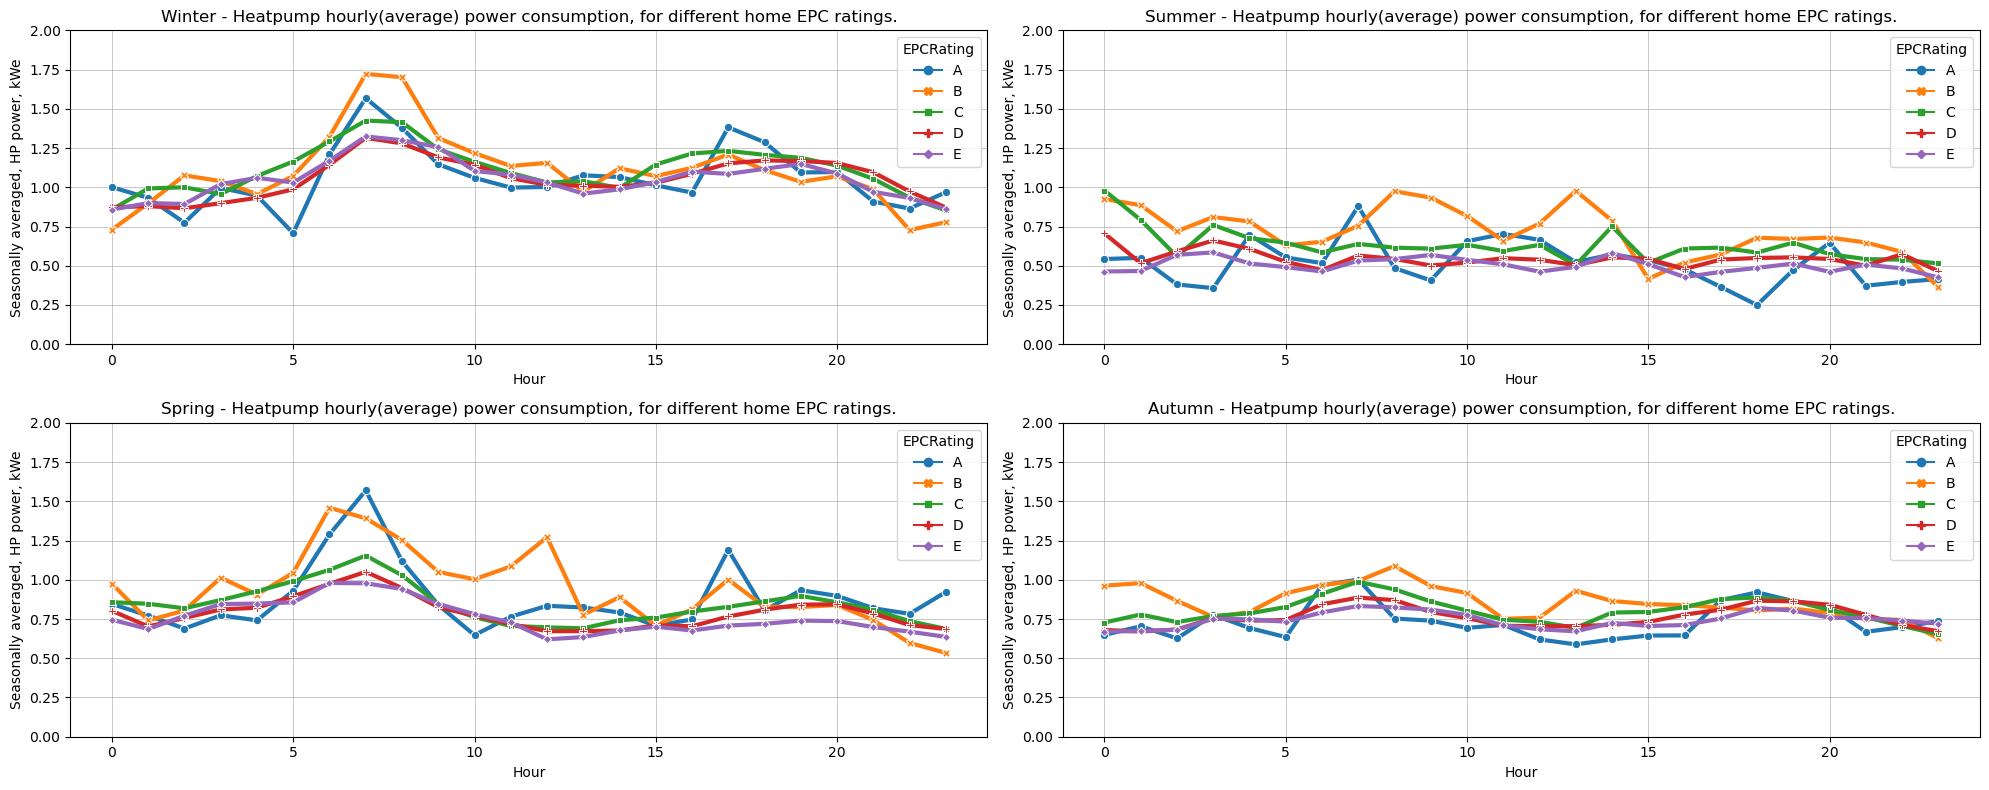

In [33]:
PvtTableA = pd.pivot_table(MasterDF, values='Hourly_Heat_Pump_Power_Consumed', index='Hour',columns=['Seasons','EPCRating'],aggfunc='mean')
PvtTableA.drop(columns='F', level=1, axis=1,inplace=True) # EPC rating F is weird and provides noisy data.
fignums_1 = 0;
plt.figure(figsize=(20,8))
for Season in Seasons:
    fignums_1 += 1
    plt.subplot(2,2,fignums_1)
    sns.lineplot(PvtTableA[Season],dashes=False,markers=True,linewidth=3)
    plt.ylim(0,2)
    plt.title(f"{Season} - Heatpump hourly(average) power consumption, for different home EPC ratings.")
    plt.ylabel("Seasonally averaged, HP power, kWe")
    plt.grid(which='both',linewidth=0.5)
plt.tight_layout()
plt.savefig("3.Methodology/1_HPDemonstrationProject/SeasonalAnd_EPC_HP_PowerConsumption.png")

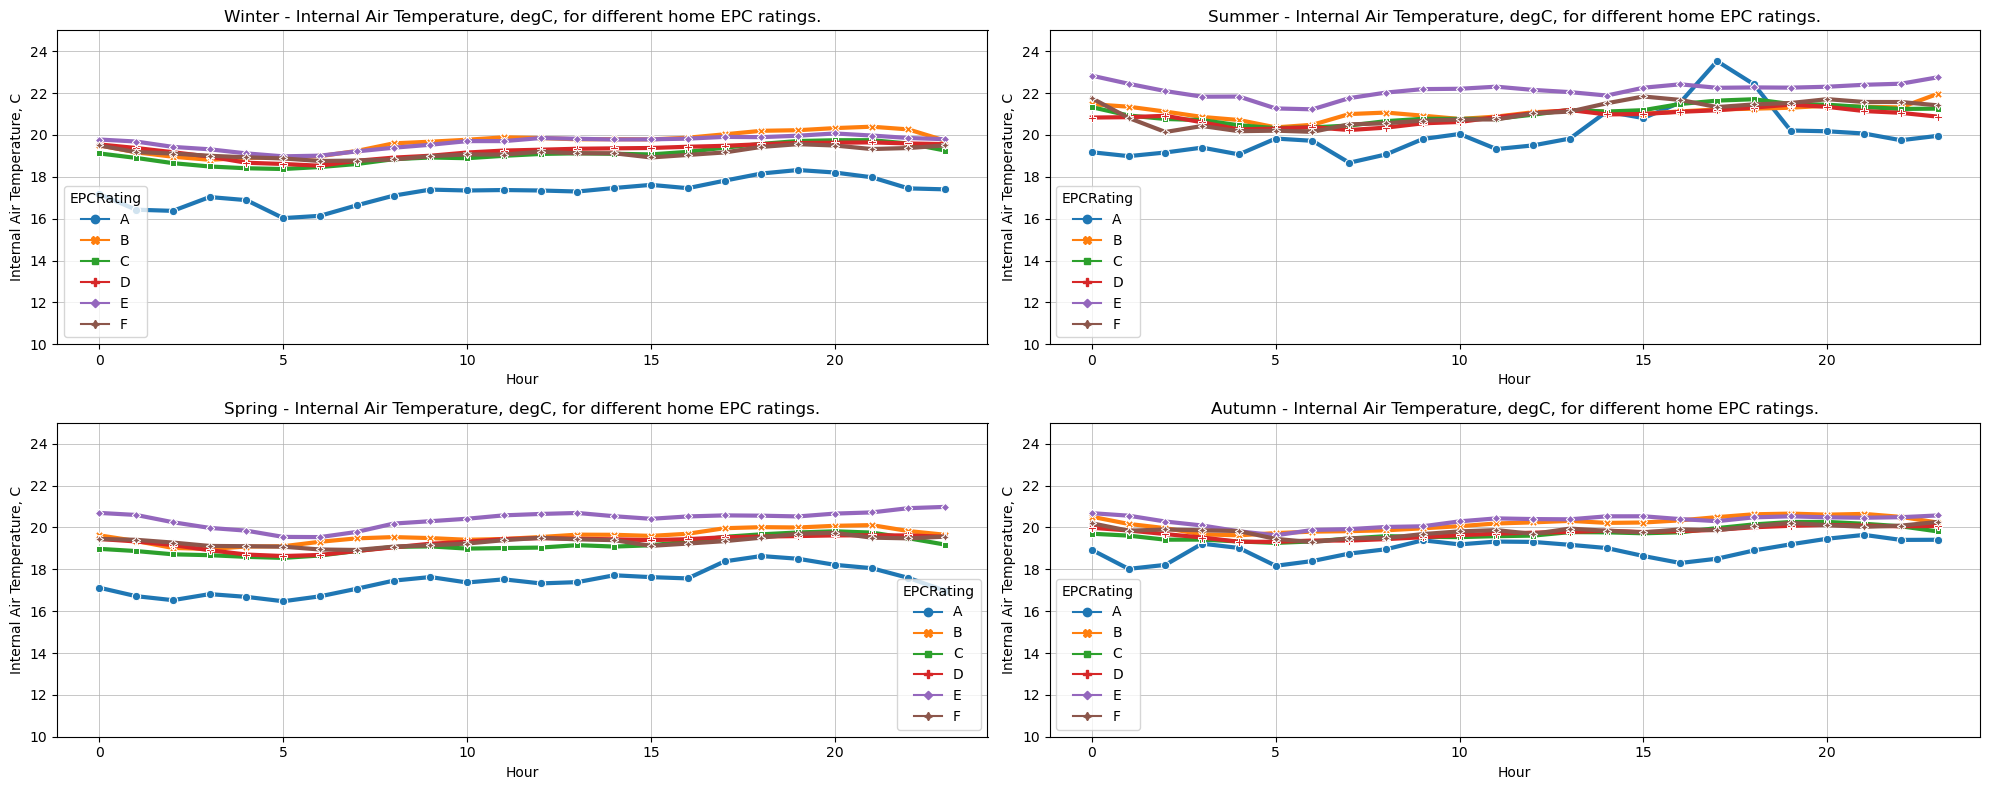

In [38]:
PvtTableB = pd.pivot_table(MasterDF, values='Internal_Air_Temperature', index='Hour',columns=['Seasons','EPCRating'],aggfunc='mean')
fignums_1 = 0;
plt.figure(figsize=(20,8))
for Season in Seasons:
    fignums_1 += 1
    plt.subplot(2,2,fignums_1)
    sns.lineplot(PvtTableB[Season],dashes=False,markers=True,linewidth=3)
    plt.ylim(10,25)
    plt.title(f"{Season} - Internal Air Temperature, degC, for different home EPC ratings.")
    plt.ylabel("Internal Air Temperature, C")
    plt.grid(which='both',linewidth=0.5)
plt.tight_layout()
plt.savefig("3.Methodology/1_HPDemonstrationProject/SeasonalAnd_EPC_InternalAirTemperature.png")

In [5]:
PvtTable = pd.pivot_table(MasterDF, values='Hourly_Heat_Pump_Power_Consumed', index=['Hour'],columns='Seasons',aggfunc='mean')
PvtTable['All_Year'] = PvtTable.mean(axis=1)
plt.figure(figsize=(16,9))
plt.title("Heatpump hourly(average) power consumption, across different seasons.")
sns.lineplot(PvtTable,dashes=False,markers=True,linewidth=3)
plt.ylabel("Seasonally averaged, Hourly Heatpump power consumed, kWe")
plt.ylim(0,2)
plt.xticks(range(0,24,1))
plt.grid(which='both',linewidth=0.5)
plt.tight_layout()
plt.savefig("3.Methodology/1_HPDemonstrationProject/SeasonalHP_PowerConsumption.png")
plt.close('all')

In [6]:
FilteredDF = MasterDF.loc[(MasterDF['ImmersionHeater_InService_Thresh_1Wth'] == '2_ImmerHeater_OutOfService') 
                     & (MasterDF['HP_CircPumpInService_Thresh_1Wth'] == '1_CP_InService')
                     & (MasterDF['Hourly_Heat_Pump_Power_Consumed'] > 0.2)
                     & (MasterDF['COP_H2'] < 8)].copy()
FilteredDF.dropna(subset = ['Temperature_Makeup', 'COP_H4'],inplace=True)

In [7]:
X = np.arange(0,35)
ASHPCOP00 = 6.08-0.09*X+0.0005*X*X
ASHPCOP = 4.08-0.09*X+0.0008*X*X

In [15]:
plt.figure(figsize=(60,20))
fignums_1 = 0
for Season in Seasons:
    fignums_1 += 1
    plt.subplot(5,7,fignums_1)
    SeasonalDF = FilteredDF.loc[(FilteredDF['Seasons'] == Season)]
    XValues = SeasonalDF["Temperature_Makeup"]
    YValues = SeasonalDF["COP_H4"]
    ASHPCOP1,coeff_A1,YIntercpt_A1,ASHPCOP2,coeff_B1,coeff_B2,YIntercptB = GetPolyCoefficients(XValues,YValues)
    Samples1 = SeasonalDF.shape[0]
    #Title = f'\n{Season} ## 1 < COP H2 < 8 ## HP Power > 0.2kWe ## Immersion Heater Out of service ## Circulating Pump In service ## Sample points {Samples1}.'
    Title = f'\n{Season} ## Sample points {Samples1}.'
    plt.title(Title)
    sns.scatterplot(data=SeasonalDF,x=XValues,y=YValues,linewidth=0,alpha=0.5)
    sns.lineplot(x=X,y=ASHPCOP00, color='red',label='Original Curve = (0.0005*X*X - 0.09*X + 6.08)',linewidth=5)
    sns.lineplot(x=X,y=ASHPCOP, color='blue',label='Modified Curve = (0.0008*X*X - 0.09*X + 4.08)',linewidth=5)
    sns.lineplot(x=X,y=ASHPCOP1, color='black',label=f'LinearFit = ({round(coeff_A1,4)}*X + {round(YIntercpt_A1,4)})',linewidth=5)
    sns.lineplot(x=X,y=ASHPCOP2, color='purple',label=f'PolyFit = ({round(coeff_B1,4)}*X*X + {round(coeff_B2,4)}*X + {round(YIntercptB,3)})',linewidth=5)
    plt.ylim(0,8)
    plt.grid(which='both',linewidth = 0.5)
    plt.legend(loc='best')
    plt.tight_layout()
    print(f"{Season} = LINEAR = {round(coeff_A1,4)}*X + {round(YIntercpt_A1,4)} ## POLY = {round(coeff_B1,4)}*X*X + {round(coeff_B2,4)}*X + {round(YIntercptB,3)}")
    #
    for EPC in EPCRatings:
        fignums_1 += 1
        plt.subplot(5,7,fignums_1)
        EPC_DF = SeasonalDF.loc[(SeasonalDF['EPCRating'] == EPC)]
        XValues = EPC_DF["Temperature_Makeup"]
        YValues = EPC_DF["COP_H4"]
        ASHPCOP1,coeff_A1,YIntercpt_A1,ASHPCOP2,coeff_B1,coeff_B2,YIntercptB = GetPolyCoefficients(XValues,YValues)
        Samples1 = EPC_DF.shape[0]
        Title = f'{Season} For EPC Rating [{EPC}] Sample points {Samples1}.\n'
        plt.title(Title)
        sns.scatterplot(data=EPC_DF,x=XValues,y=YValues,linewidth=0,alpha=0.5)
        sns.lineplot(x=X,y=ASHPCOP00, color='red',label='Original Curve = (0.0005*X*X - 0.09*X + 6.08)',linewidth=5)
        sns.lineplot(x=X,y=ASHPCOP, color='blue',label='Modified Curve = (0.0008*X*X - 0.09*X + 4.08)',linewidth=5)
        sns.lineplot(x=X,y=ASHPCOP1, color='black',label=f'LinearFit = ({round(coeff_A1,4)}*X + {round(YIntercpt_A1,4)})',linewidth=5)
        sns.lineplot(x=X,y=ASHPCOP2, color='purple',label=f'PolyFit = ({round(coeff_B1,4)}*X*X + {round(coeff_B2,4)}*X + {round(YIntercptB,3)})',linewidth=5)
        plt.ylim(0,8)
        plt.grid(which='both',linewidth = 0.5)
        plt.legend(loc='best')
        plt.tight_layout()
#
fignums_1 += 1
plt.subplot(5,7,fignums_1)
XValues = FilteredDF["Temperature_Makeup"]
YValues = FilteredDF["COP_H4"]
ASHPCOP1,coeff_A1,YIntercpt_A1,ASHPCOP2,coeff_B1,coeff_B2,YIntercptB = GetPolyCoefficients(XValues,YValues)
Samples2 = FilteredDF.shape[0]
#Title = f'ALL SEASONS ## 1 < COP H2 < 8 ## HP Power > 0.2kWe ## Immersion Heater Out of service ## Circulating Pump In service ## Sample points {Samples2}.\n'
Title = f'\nAll Seasons ## Sample points {Samples2}.'
plt.title(Title)
sns.scatterplot(data=FilteredDF,x=XValues,y=YValues,linewidth=0,alpha=0.5)
sns.lineplot(x=X,y=ASHPCOP00, color='red',label='Original Curve = (0.0005*X*X - 0.09*X + 6.08)',linewidth=5)
sns.lineplot(x=X,y=ASHPCOP, color='blue',label='Modified Curve = (0.0008*X*X - 0.09*X + 4.08)',linewidth=5)
sns.lineplot(x=X,y=ASHPCOP1, color='black',label=f'LinearFit = ({round(coeff_A1,4)}*X + {round(YIntercpt_A1,4)})',linewidth=5)
sns.lineplot(x=X,y=ASHPCOP2, color='purple',label=f'PolyFit = ({round(coeff_B1,4)}*X*X + {round(coeff_B2,4)}*X + {round(YIntercptB,3)})',linewidth=5)
plt.ylim(0,8)
plt.grid(which='both',linewidth = 0.5)
plt.legend(loc='best')
plt.tight_layout()
print(f"ALL SEASON = LINEAR = {round(coeff_A1,4)}*X + {round(YIntercpt_A1,4)} ## POLY = {round(coeff_B1,4)}*X*X + {round(coeff_B2,4)}*X + {round(YIntercptB,3)}")
#
for EPC in EPCRatings:
    fignums_1 += 1
    plt.subplot(5,7,fignums_1)
    EPC_DF = FilteredDF.loc[(FilteredDF['EPCRating'] == EPC)]
    XValues = EPC_DF["Temperature_Makeup"]
    YValues = EPC_DF["COP_H4"]
    ASHPCOP1,coeff_A1,YIntercpt_A1,ASHPCOP2,coeff_B1,coeff_B2,YIntercptB = GetPolyCoefficients(XValues,YValues)
    Samples1 = EPC_DF.shape[0]
    Title = f'\nALL SEASONS - For EPC Rating [{EPC}] Sample points {Samples1}.'
    plt.title(Title)
    sns.scatterplot(data=EPC_DF,x=XValues,y=YValues,linewidth=0,alpha=0.5)
    sns.lineplot(x=X,y=ASHPCOP00, color='red',label='Original Curve = (0.0005*X*X - 0.09*X + 6.08)',linewidth=5)
    sns.lineplot(x=X,y=ASHPCOP, color='blue',label='Modified Curve = (0.0008*X*X - 0.09*X + 4.08)',linewidth=5)
    sns.lineplot(x=X,y=ASHPCOP1, color='black',label=f'LinearFit = ({round(coeff_A1,4)}*X + {round(YIntercpt_A1,4)})',linewidth=5)
    sns.lineplot(x=X,y=ASHPCOP2, color='purple',label=f'PolyFit = ({round(coeff_B1,4)}*X*X + {round(coeff_B2,4)}*X + {round(YIntercptB,3)})',linewidth=5)
    plt.ylim(0,8)
    plt.grid(which='both',linewidth = 0.5)
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig("3.Methodology/HPDemonstrationProject/All_DataPresentation.png")
plt.close('all');print("Done")

Winter = LINEAR = -0.0814*X + 4.1701 ## POLY = -0.0*X*X + -0.0802*X + 4.162
Summer = LINEAR = 0.0006*X + 2.9805 ## POLY = -0.0005*X*X + 0.0074*X + 2.961
Spring = LINEAR = -0.0611*X + 3.889 ## POLY = -0.0027*X*X + 0.006*X + 3.51
Autumn = LINEAR = -0.0655*X + 3.984 ## POLY = -0.0034*X*X + 0.0133*X + 3.584
ALL SEASON = LINEAR = -0.0538*X + 3.762 ## POLY = -0.0041*X*X + 0.0471*X + 3.221
Done


In [10]:
# Plotting HEATMAP by DaysOfTheYear and WeekNumber
Params = ['Temperature_Makeup','COP_H4','Hourly_Heat_Pump_Power_Consumed']
plt.figure(figsize=(30,25))
fignums_2 = 0
for value in Params:
    fignums_2 += 1
    PvtTable1 = pd.pivot_table(FilteredDF, values=value, index=['Hour'],columns='DaysOfTheYear',aggfunc='mean')
    plt.subplot(3,1,fignums_2)
    plt.title(f"Day/Hourly ({value}) throughout the year.")
    sns.heatmap(PvtTable1)
    plt.ylabel("Hours")
    plt.xlabel("Days of the Year")
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("3.Methodology/HPDemonstrationProject/Daily_PumpPerformance.png")
plt.close('all')

In [11]:
plt.figure(figsize=(20,15))
fignums_3 = 0
for value in Params:
    fignums_3 += 1
    PvtTable1 = pd.pivot_table(FilteredDF, values=value, index=['Hour'],columns='WeekNumber',aggfunc='mean')
    plt.subplot(3,1,fignums_3)
    plt.title(f"Weekly/Hourly ({value}) throughout the year.")
    sns.heatmap(PvtTable1)
    plt.ylabel("Hours")
    plt.xlabel("Week of the Year")
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("3.Methodology/HPDemonstrationProject/Weekly_PumpPerformance.png")
plt.close('all')

In [12]:
plt.figure(figsize=(10,15))
fignums_4 = 0
for value in Params:
    fignums_4 += 1
    PvtTable1 = pd.pivot_table(FilteredDF, values=value, index=['Hour'],columns='Month',aggfunc='mean')
    plt.subplot(3,1,fignums_4)
    plt.title(f"Month/Hourly ({value}) throughout the year.")
    sns.heatmap(PvtTable1)
    plt.ylabel("Hours")
    plt.xlabel("Month of the Year")
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("3.Methodology/HPDemonstrationProject/Monthly_PumpPerformance.png")
plt.close('all')